In [1]:
# silly autoreload to avoid restarting the kernel every time
%load_ext autoreload
%autoreload 2

import gc
import time
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from ekf.plotting import plotter
from ekf.utils import add_noise_with_snr
from ekf.filters.config import DynamicsConfig
from ekf.filters.ekf import EKF
from scipy.integrate import odeint

seed = 29
np.random.seed(seed)

/home/ridley/.cache/pypoetry/virtualenvs/vindy-ufNc4RT7-py3.11/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


LaTeX is installed. Using LaTeX for rendering.


# EKF-SINDy with reaction-diffusion PDE (in POD space)

Consider a reaction-diffusion PDE

$$
\begin{align}
u_t &= 0.1\nabla^2 u +(1-A^2)u + \mu A^2 v,\\
v_t &= 0.1\nabla^2 v - \mu A^2 u + (1 - A^2)v,\\
A^2 &= u^2+v^2.
\end{align}
$$

with a periodic starting condition

$$
\begin{align}
u(x, y,0;\beta)&=\tanh\bigg(\beta\sqrt{x^2+y^2}\cos\bigg(\angle(x+iy)-\beta\sqrt{x^2+y^2}\bigg)\bigg),\\
v(x,y,0;\beta)&=\tanh\bigg(\beta\sqrt{x^2+y^2}\sin\bigg(\angle(x+iy)-\beta\sqrt{x^2+y^2}\bigg)\bigg).

\end{align}
$$

We consider simulations for $\beta=1.1$ and $\mu \in [0.9, 1.3]$. We consider a $\Delta t = 0.05$ with a time window $T=60$. The spatial domain is $[-L, L]^2$ for L = 10, and the spatial step is $\Delta h = 0.4$.

## Selecting POD modes

We extracte the simulated data and compute the top 20 modes. It is well known that the spiral reaction-diffusion PDE is characterized by two oscillating modes. However, these only capture spatial information, hence we must be careful if we try to identify the temporal dynamics with such modes.

Also, the data is not scaled, it does not have unit variance nor zero-mean. Such scaling should be performed during inference as well, with the mean and scaling from the training data. 

We use the <code>scipy.linalg.sparse</code> package for computing the truncated SVD. It sorts the modes in **ascending** order... take this into account.

In [15]:
# Extract data, and stack it

start_t = time.time()

filename = "../../simulation_data/rd_spiral/rd_spiral_mu_0.800_to_1.600_d1_0.01_d2_0.01_m_1_beta_1.1.npz"
data = np.load(filename)

print(f"Data loaded in {time.time() - start_t:.4f} seconds.")

# Reshape data, the third dimension are the number of parameter instances

u = data['u']
v = data['v']
t = u.shape[2]

flat_dim = u.shape[0] * u.shape[1]

mu_instances = u.shape[3]

u_matrix = u.reshape((flat_dim, t * mu_instances))
v_matrix = v.reshape((flat_dim, t * mu_instances))
full_uv = np.vstack((u_matrix, v_matrix))

# # Scaling and zero-centering, is it necessary in this case?
# mean_uv = np.mean(full_uv, axis=1, keepdims=True)
# full_uv = full_uv - mean_uv

top_k = 30
start_t = time.time()
U, S, VT = svds(full_uv, k=top_k, which='LM')
print(f"SVD computed in {time.time() - start_t:.4f} seconds.")

# Since the matrix is big, just get rid of them after computing the SVD. We also keep full_uv for later use. Also we reverse the columns of U
U = U[:, ::-1]  
S = S[::-1]     # Reverse singular values
full_uv = full_uv.reshape((-1, t, mu_instances))
print(f'full_uv shape: {full_uv.shape}')

del u, v, u_matrix, v_matrix, data
gc.collect()


Data loaded in 0.0716 seconds.
SVD computed in 3.7726 seconds.
full_uv shape: (5000, 801, 9)


12079

Cumulative energy and scree plot. We also plot the trajectory for $\mu=0.8$ of the top-$k$ modes.

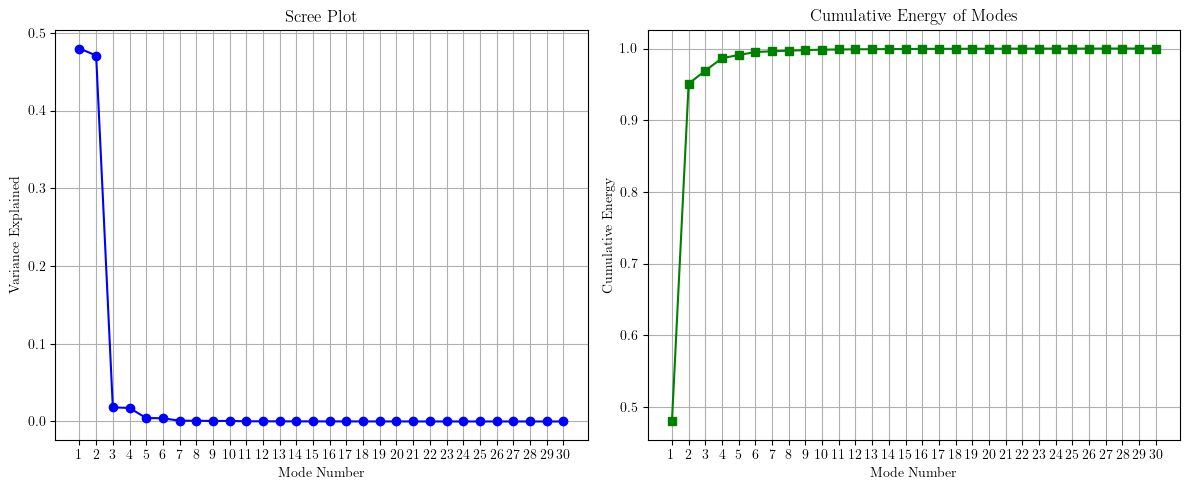

In [16]:
# Singular values
energy = S**2
total_energy = np.sum(energy)
explained_variance = energy / total_energy  # variance explained by each mode
cumulative_energy = np.cumsum(explained_variance)

modes = np.arange(1, len(S)+1)

plt.figure(figsize=(12,5))

# Scree plot
plt.subplot(1,2,1)
plt.plot(modes, explained_variance, 'o-', color='blue')
plt.xlabel('Mode Number')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.grid(True)
plt.xticks(modes)  # Set x-axis ticks to integers

# Cumulative energy
plt.subplot(1,2,2)
plt.plot(modes, cumulative_energy, 's-', color='green')
plt.xlabel('Mode Number')
plt.ylabel('Cumulative Energy')
plt.title('Cumulative Energy of Modes')
plt.grid(True)
plt.xticks(modes)  # Set x-axis ticks to integers

plt.tight_layout()
plt.show()

U[:, :top_k] shape: (5000, 4)


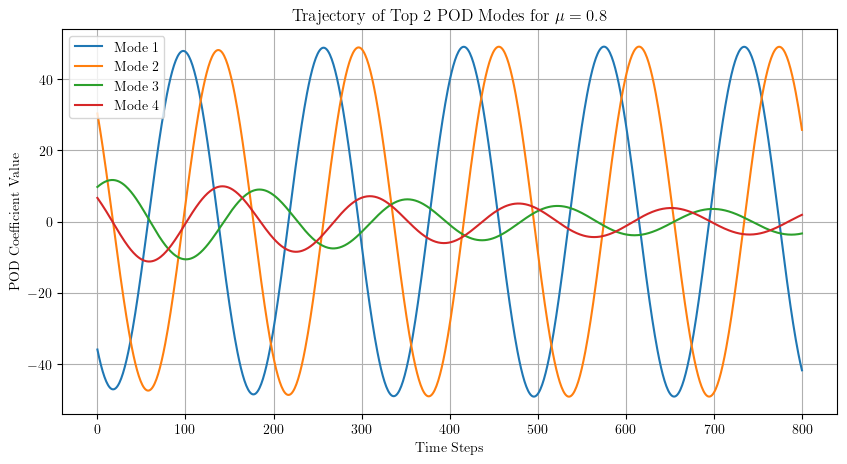

In [25]:
# plot trajectory of top k modes

top_k = 4
mu_index = 0
pod_projection = full_uv[:, :, mu_index].T @ U[:, :top_k]  # Shape (time, modes)

print(f'U[:, :top_k] shape: {U[:, :top_k].shape}')
# pod_projection = pod_projection.T  # Shape (time, modes)
plt.figure(figsize=(10, 5))
for i in range(top_k):
    plt.plot(pod_projection[:, i], label=f'Mode {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('POD Coefficient Value')
plt.title('Trajectory of Top 2 POD Modes for $\mu=0.8$')
plt.legend()
plt.grid(True)
plt.show()

Now we would like to identify the dynamics in POD coordinates. First let's take a look at how the top 2 modes evolve. In this case we can also see what SINDy identifies coupled oscillators in POD coordinates, which is very nice, we have very simple dynamics.

In [33]:
# We select the top k modes to feed into SINDy, also we are considering
# 61 parameter instances, each trajectory of length 801
top_k = 2
mu_index = 0
pod_projection = full_uv[:, :, mu_index].T @ U[:, :top_k]

# Now we fit the first parameter instance (corresponding to the zeroth index and mu=0.8)
poly_lib = ps.PolynomialLibrary(degree=3)
fourier_lib = ps.FourierLibrary(n_frequencies=1)
combined_lib = poly_lib + fourier_lib

model = ps.SINDy(feature_library=combined_lib,
                 optimizer=ps.STLSQ(threshold=5e-2))

model.fit(pod_projection, t=0.05)
model.print()


(x0)' = -0.789 x1
(x1)' = 0.789 x0


We create the "callback" for preprocessing the observations fed into the filter via POD projection (on the top 2 modes). In our case we already have a PODProjection callback in our library, however, you can define whatever callback you want of course. Maybe even zero-center the incoming observations (using the training mean), up to you. 

We load the data corresponding to our transient and we run the filter on that data. We can there monitor how the coefficients change, and the absolute error w.r.t. actual measurements.

In [ ]:
from ekf.filters.callbacks import PODProjection

ekf_callback = PODProjection(pod_modes=U[:, -top_k:])
filename = "../../simulation_data/rd_spiral/rd_spiral_mu_0.700_to_1.500_d1_0.01_d2_0.01_m_1_beta_1.1.npz"
data = np.load(filename)

What if system suddenly becomes conservative? So the damping term $\delta$ goes to zero abruptly. We define the constraint object and set a very small noise (can you do the update at the same time?)

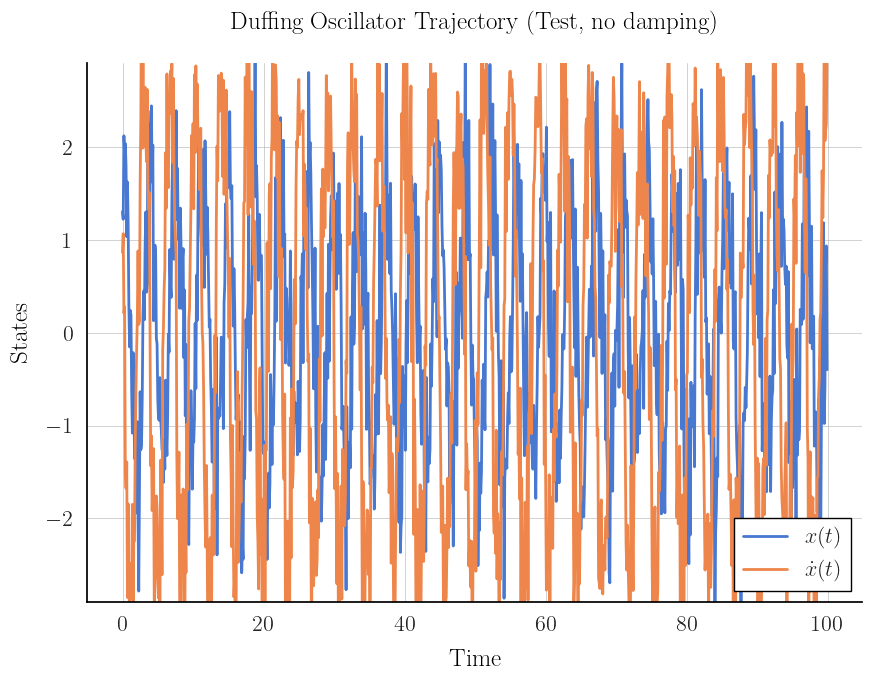

In [ ]:
t_conservation = 0.0
time_instances = np.arange(0, 100, 0.1)
x_0_test = np.random.randn(1, 2) * std + mean_ic
x_test = odeint(duffing_oscillator, x_0_test[0, :], time_instances, args=(params, t_conservation))
x_test_noiseless = x_test.copy()
x_test = add_noise_with_snr(x_test, snr=8)

fig, ax = plotter.plot_trajectory(x_test, time_instances, x_tick_skip=20, title='Duffing Oscillator Trajectory (Test, no damping)', xlabel='Time', ylabel='States',
                                   state_names=["$x(t)$", "$\dot{x}(t)$"], ylim=(-2.9, 2.9))

# plt.savefig("/home/carlos/Downloads/duffing_test_no_damping.svg", bbox_inches='tight')
plt.show()

And now we setup the Kalman filter

In [8]:
from ekf.plotting import plotter
from ekf.filters.ekf import EKF

# EKF configuration, will probably end up badly because there are way too many terms...
p0 = np.diag([1e-8, 1e-8, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6]) # initial state covariance
q = np.diag([1e-8, 1e-8, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6]) # process noise covariance
r = np.diag([4e-5, 4e-5])

library_terms = model.get_feature_names()
coeffs = model.coefficients()
variables = model.feature_names
print(f'library_terms: {library_terms}')

# We are tracking the entire library
tracked_terms = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
               [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

# x0 = x_0_test[0, :]
# config = DynamicsConfig(variables, library_terms, tracked_terms, coeffs, q, r)
# filter = EKF(x0, p0, config=config, integration_rule='RK4')

# dts = np.diff(time_instances)
# observations = x_test[1:, :]
# filter.run_filter(dts, observations)

# filter_estimates = filter.states.xcal_states[:, 0:2]
# sdevs = filter.states.sdev_states[:, 0:2]

# fig, x = plotter.plot_trajectory(filter_estimates, time_instances, sdevs, x_tick_skip=20, title='Harmonic oscillator - EKF estimates (no constraints)', xlabel='Time', ylabel='States', 
#                                  state_names=["$x(t)$", "$\dot{x}(t)$"], ylim=(-2.9, 2.9))
# # plt.savefig("/home/carlos/Downloads/duffing_no_constraint.svg", bbox_inches='tight')
# plt.show()
# damping_term = filter.states.xcal_states[:, [2, 3]]
# damping_sdev = filter.states.sdev_states[:, [2, 3]]

# fig, x = plotter.plot_trajectory(damping_term, time_instances, damping_sdev, x_tick_skip=20, title="Damping coefficients $\delta_1(t)$ and $\delta_2(t)$ (no constraints)", xlabel='Time', ylabel='Damping',
#                                  state_names=["$-\delta_1 (t)$ (with $\dot{x}$)", "$-\delta_2 (t)$ (with $\dot{x}^3$)"], palette="viridis",
#                                  ylim=(-0.8, 0.45))
# # plt.savefig("/home/carlos/Downloads/duffing_damping_no_constraint.svg", bbox_inches='tight')
# plt.show()
# # compute energy
# def compute_dE(x, x0):
#      return np.array([energy(x, alpha, beta) - energy(x0, alpha, beta)])
# delta_x0 = lambda x: compute_dE(x, x0)

# # is energy conserved?
# energy_diff = [delta_x0(xi) for xi in filter_estimates]
# energy_diff = np.array(energy_diff)
# fig, ax = plotter.plot_trajectory(energy_diff, time_instances, x_tick_skip=20, title='Energy deviation with filter estimates (no constraint)', xlabel='Time', ylabel='Energy deviation', 
#                                   state_names=["$H(x(t)) - H(x(t_0))$"], ylim=(-3.2, 0.9))
# # plt.savefig("/home/carlos/Downloads/duffing_energy_no_constraint.svg", bbox_inches='tight')
# plt.show()



library_terms: ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3']
